# V_SLOPE projection

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from shapely.geometry import mapping
from shapely.geometry import box
from rasterio.mask import mask
import matplotlib as mpl
from matplotlib.colors import LogNorm, SymLogNorm
import os
import mplstereonet
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

import warnings
warnings.filterwarnings("ignore")

In [19]:
def tiff2arr(tif_fid, mask=None):
    if mask is not None:
        with rasterio.open(tif_fid) as src:
            feature = [mapping(mask)]
            masked_band = mask(src, feature, crop=True, all_touched=True)
            arr = masked_band[0]
            pixel_georeferences = masked_band[1] 
            return arr, pixel_georeferences

    else: 
        with rasterio.open(tif_fid) as src:
            arr = src.read(1)
            return arr

LiCSAR interferograms are provided in geographical coordinates. The line of sight unit vectors are normally given by a flight direction measured clockwise from the north. and the incidence angle is measured from the nadir to the horizontal. The provided vectors show unit vectors measured from the surface towards the satellite (This is a Zenith measurement (?))

In [20]:
E_A_fid = "./data/129A_05935_131313/129A_05935_131313.geo.E.tif"
N_A_fid = "./data/129A_05935_131313/129A_05935_131313.geo.N.tif"
UP_A_fid = "./data/129A_05935_131313/129A_05935_131313.geo.U.tif"

E_D_fid = "./data/063D_05860_131313/063D_05860_131313.geo.E.tif"
N_D_fid = "./data/063D_05860_131313/063D_05860_131313.geo.N.tif"
UP_D_fid = "./data/063D_05860_131313/063D_05860_131313.geo.U.tif"

# E = tiff2arr(E_A_fid)
# N = tiff2arr(N_A_fid)
# UP = tiff2arr(UP_A_fid)

E = tiff2arr(E_A_fid)
N = tiff2arr(N_A_fid)
UP = tiff2arr(UP_A_fid)

x, y = 1200, 1200
print((N[1500, 1500], E[1500, 1500], UP[1500, 1500]))

(-0.11236729, -0.6145416, 0.7808407)


In [21]:
def ENU2angles(E, N, UP):
    """
    Return the flight direction and incidence angles based on the ENU decomposed vectors,
    where the given vector points to the southern hemisphere and has the ground --> satellite
    direction.
    """
    # Mask out zeros from matrix
    E_mask = np.ma.masked_where((E == 0), E)
    N_mask = np.ma.masked_where((N == 0), N)
    UP_mask = np.ma.masked_where((UP == 0), UP)

    ##########################
    LOS_dir = np.rad2deg(np.arctan(N_mask/E_mask))
    if np.mean(LOS_dir)<0:
        flight_dir = abs(LOS_dir)+180
        incidence_angle = np.rad2deg(np.arccos(UP_mask))
        return flight_dir, incidence_angle
    else:
        flight_dir = -LOS_dir+360
        incidence_angle = np.rad2deg(np.arccos(UP_mask))
        return flight_dir, incidence_angle

flight_dir, incidence_angle = ENU2angles(E, N, UP)
LOS_dir = flight_dir+-270
mean_flight_dir = np.mean(flight_dir)
mean_incidence_angle = np.mean(incidence_angle)
mean_flight_dir, mean_incidence_angle

(349.69448249300893, 39.07939516736717)

In [22]:
E_mask = np.ma.masked_where((E == 0), E)
N_mask = np.ma.masked_where((N == 0), N)
UP_mask = np.ma.masked_where((UP == 0), UP)

In [23]:
def norm_3com(N,E,U):
    return np.sqrt((E)**2+(N)**2+(U)**2)

## Decomposition based on handweger et al 2019
## uses no further rotations or flips and coincides with LiCSBAS product 

calc_N, calc_E, calc_UP = [np.sin(np.deg2rad(mean_flight_dir))*np.sin(np.deg2rad(mean_incidence_angle)),
-np.cos(np.deg2rad(mean_flight_dir))*np.sin(np.deg2rad(mean_incidence_angle)),
np.cos(np.deg2rad(mean_incidence_angle))]
print([calc_N,calc_E,calc_UP])
norm_3com(calc_N,calc_E,calc_UP)


[-0.11277605090592431, -0.6202270072182271, 0.7762731618825848]


1.0

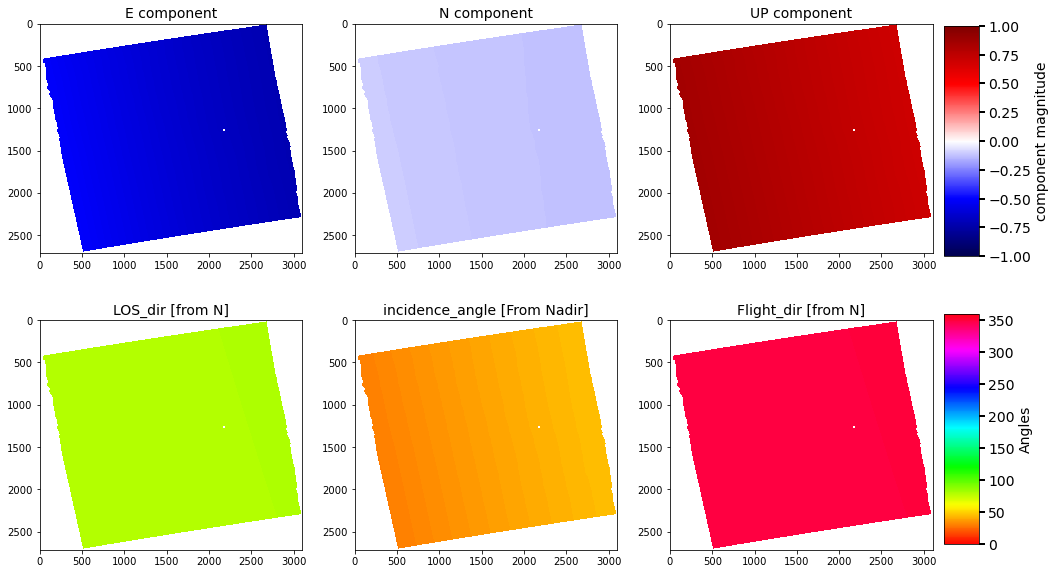

In [24]:
fig, ax = plt.subplots(2,3, figsize=(16,10))
ax=ax.ravel()
im = ax[0].imshow(E_mask, cmap="seismic", vmin=-1,vmax=1)
ax[0].set_title("E component", size=14)
im = ax[1].imshow(N_mask, cmap="seismic", vmin=-1,vmax=1)
ax[1].set_title("N component", size=14)
im = ax[2].imshow(UP_mask, cmap="seismic", vmin=-1,vmax=1)
ax[2].set_title("UP component", size=14)

cax = fig.add_axes([0.91, 0.545, 0.03, 0.32])
cmap = mpl.cm.seismic
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
cbar = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='vertical')
cbar.set_label('component magnitude', size=14)
cbar.ax.tick_params(labelsize=14, width=2, length=6) 

im = ax[3].imshow(LOS_dir, cmap="hsv", vmin=0,vmax=360)
ax[3].set_title("LOS_dir [from N]", size=14)
im = ax[4].imshow(incidence_angle, cmap="hsv", vmin=0,vmax=360)
ax[4].set_title("incidence_angle [From Nadir]", size=14)
im = ax[5].imshow(flight_dir, cmap="hsv", vmin=0,vmax=360)
ax[5].set_title("Flight_dir [from N]", size=14)

cax = fig.add_axes([0.91, 0.145, 0.03, 0.32])
cmap = mpl.cm.hsv
norm = mpl.colors.Normalize(vmin=0, vmax=360)
cbar = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='vertical')
cbar.set_label('Angles', size=14)
cbar.ax.tick_params(labelsize=14, width=2, length=6) 

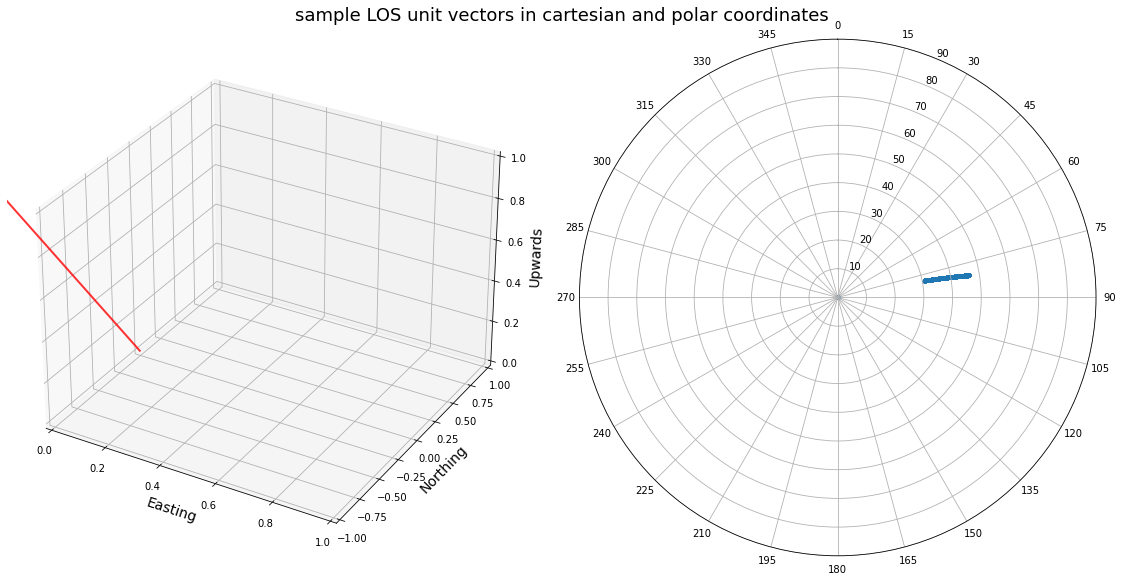

In [25]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121, projection='3d')

ax.quiver(0,0,0,
    E[1500, 1500],N[1500, 1500], UP[1500, 1500], 
    color = 'red', alpha = .8, lw = 2, arrow_length_ratio=0.1)
ax.set_xlim(0,1)
ax.set_xlabel("Easting", size=14)
ax.set_ylim(-1,1)
ax.set_ylabel("Northing", size=14)
ax.set_zlim(0,1)
ax.set_zlabel("Upwards", size=14)


ax = fig.add_subplot(122, projection='polar')

ax.set_rlim((0,90))
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_thetagrids(np.arange(0, 360, 15), labels=np.arange(0, 360, 15))
ax.scatter(np.deg2rad(LOS_dir.ravel()[::100]), incidence_angle.ravel()[::100], alpha=0.75, s=5)

fig.suptitle("sample LOS unit vectors in cartesian and polar coordinates", size=18)
fig.tight_layout()


## Toy gausian hill

In order to assess how does the velocity projection performs among the different surface slopes, a toy gaussian hill is created and with its topographic features (slope and aspect using the same reference system as above) the N, E and UP components are produced do the velocity projection along the downslope direction.

In [26]:
def gaussian_hill_elevation(n, b = 2.5):
    x, y = np.meshgrid(np.linspace(-b,b,n),
                        np.linspace(-b,b,n))

    z = np.exp(-x*x-y*y)
    return (x, y, z)

n = 211
x, y, z = gaussian_hill_elevation(n, b=2.5)
z=z*100

dx,dy = np.gradient(z)
slope_DEM = np.rad2deg(np.arctan(np.sqrt((dx**2) + (dy**2))))
aspect_DEM = np.rad2deg(np.arctan2(dy, -dx))+180

[Text(1, 0, 'N'),
 Text(90, 0, 'E'),
 Text(180, 0, 'S'),
 Text(270, 0, 'W'),
 Text(360, 0, 'N')]

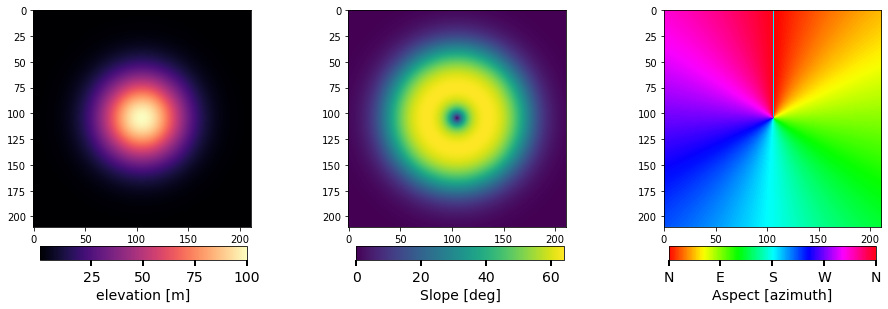

In [27]:
fig, ax = plt.subplots(1,3, figsize=(16,4))
im = ax[0].imshow(z, cmap="magma")
cax = fig.add_axes([0.15, 0.01, 0.18, 0.05])
cmap = mpl.cm.magma
norm = mpl.colors.Normalize(vmin=np.min(z), vmax=np.max(z))
cbar = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='horizontal')
cbar.set_label('elevation [m]', size=14)
cbar.ax.tick_params(labelsize=14, width=2, length=6) 

im = ax[1].imshow(slope_DEM, cmap="viridis")
cax = fig.add_axes([0.425, 0.01, 0.18, 0.05])
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=np.min(slope_DEM), vmax=np.max(slope_DEM))
cbar = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='horizontal')
cbar.set_label('Slope [deg]', size=14)
cbar.ax.tick_params(labelsize=14, width=2, length=6) 

im = ax[2].imshow(aspect_DEM, cmap="hsv")
cax = fig.add_axes([0.696, 0.01, 0.18, 0.05])
ang = [1,90,180,270,360]
cmap = mpl.cm.hsv
norm = mpl.colors.Normalize(vmin=np.min(aspect_DEM), vmax=np.max(aspect_DEM))
cbar = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='horizontal', ticks=ang)
cbar.set_label('Aspect [azimuth]', size=14)
cbar.ax.tick_params(labelsize=14, width=2, length=6) 
cardinal=["N","E","S","W","N"]
cax.set_xticklabels(cardinal, minor=False)

## V_Slope using Aslan decomposition

In [28]:
#LOS compoments with mean_flight_dir, mean_incidence_angle (For Aslan)
D_N = np.sin(np.deg2rad(mean_incidence_angle))*np.sin(np.deg2rad(180 - mean_flight_dir))
D_E = np.sin(np.deg2rad(mean_incidence_angle))*np.sin(np.deg2rad(270 - mean_flight_dir))
D_U = np.cos(np.deg2rad(mean_incidence_angle))
print((mean_flight_dir, mean_incidence_angle))
print((D_N, D_E, D_U))

slope_N = np.cos(np.deg2rad(slope_DEM))*np.sin(np.deg2rad(aspect_DEM-90))
slope_E = -1*np.cos(np.deg2rad(slope_DEM))*np.cos(np.deg2rad(aspect_DEM-90))
slope_U = np.sin(np.deg2rad(slope_DEM))


(349.69448249300893, 39.07939516736717)
(-0.11277605090592396, -0.6202270072182272, 0.7762731618825848)


This slope decomposition reflects slope vectors that point uphill and also considers E-N but no UP components in flat zones. these vectors are parallel to the dip direction. The oposite direction would represent a downslope vector

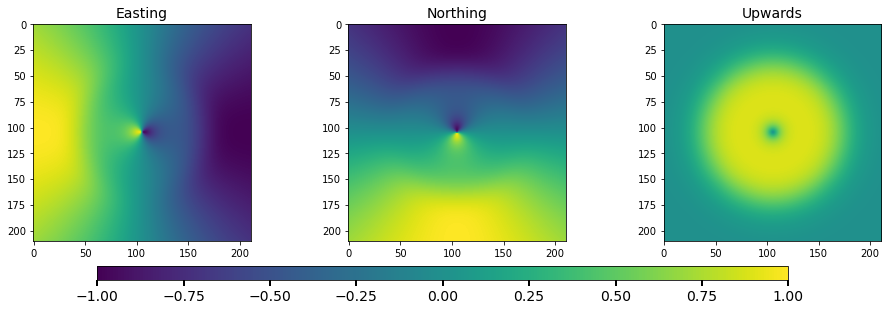

In [33]:
fig, ax = plt.subplots(1,3, figsize=(16,4))
im = ax[0].imshow(slope_E, cmap="viridis", vmin=-1, vmax=1)
ax[0].set_title('Easting', size=14)

im = ax[1].imshow(slope_N, cmap="viridis", vmin=-1, vmax=1)
ax[1].set_title('Northing', size=14)


im = ax[2].imshow(slope_U, cmap="viridis", vmin=-1, vmax=1)
ax[2].set_title('Upwards', size=14)

cax = fig.add_axes([0.2, -0.01, 0.6, 0.05])
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
cmap = mpl.cm.viridis
cbar = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='horizontal')
cbar.ax.tick_params(labelsize=14, width=2, length=6) 


Text(0.5, 0, 'Upwards')

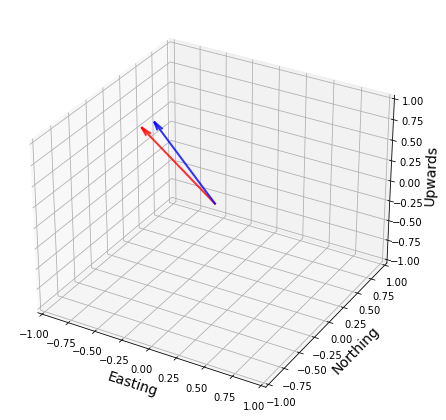

In [35]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121, projection='3d')

ax.quiver(0,0,0,
    E[1500, 1500],N[1500, 1500], UP[1500, 1500], 
    color = 'red', alpha = .8, lw = 2, arrow_length_ratio=0.1)

ax.quiver(0,0,0,
    slope_E[100,150],slope_N[100,140],slope_U[100,150], 
    color = 'blue', alpha = .8, lw = 2, arrow_length_ratio=0.1)


ax.set_xlim(-1,1)
ax.set_xlabel("Easting", size=14)
ax.set_ylim(-1,1)
ax.set_ylabel("Northing", size=14)
ax.set_zlim(-1,1)
ax.set_zlabel("Upwards", size=14)

In [30]:
# define constant LOS vel
V_LOS = 10 #mm/year

#Calculate C
C = D_N*slope_N + D_E*slope_E + D_U*slope_U

V_slope = V_LOS/C

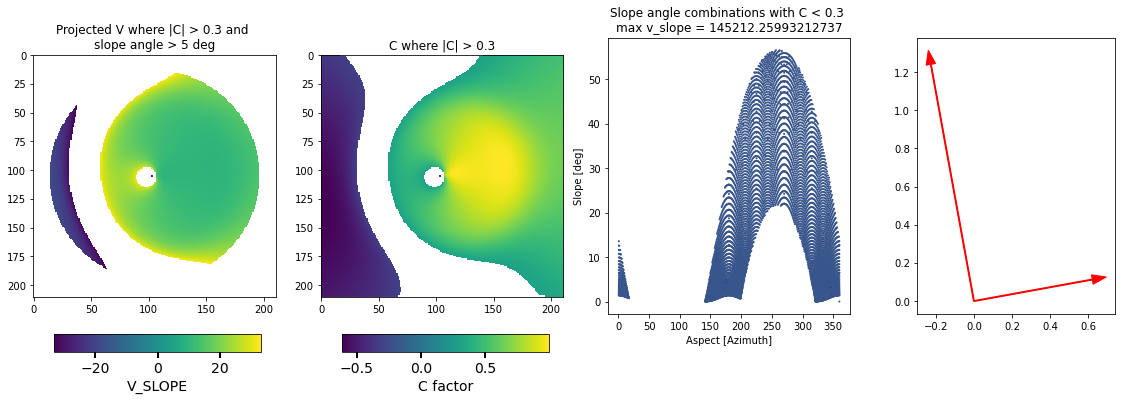

In [31]:
threshold = 0.3

C_mask = np.ma.masked_where((C > -threshold) & (C < threshold), C)
C_tr = np.ma.masked_where((abs(C) < threshold*0.99) | (abs(C) > threshold*1.18), np.ceil(abs(C)))
V_mask = np.ma.masked_where((C > -threshold) & (C < threshold) | (slope_DEM < 5), V_slope)


fig, ax = plt.subplots(1,4, figsize=(16,5))
ax=ax.ravel()
im = ax[0].imshow(V_mask)
cax = fig.add_axes([0.05, 0.01, 0.18, 0.05])
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=np.nanmin(V_mask), vmax=np.nanmax(V_mask))
cbar = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='horizontal')
cbar.set_label('V_SLOPE', size=14)
cbar.ax.tick_params(labelsize=14, width=2, length=6) 
ax[0].set_title("Projected V where |C| > {} and \nslope angle > 5 deg".format(threshold))

ax[1].imshow(C_mask)
# ax[1].imshow(abs(C_tr), cmap="magma")
cax = fig.add_axes([0.3, 0.01, 0.18, 0.05])
norm = mpl.colors.Normalize(vmin=np.nanmin(C), vmax=np.nanmax(C))
ax[1].set_title("C where |C| > {}".format(threshold))

cbar = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='horizontal')
cbar.set_label('C factor', size=14)
cbar.ax.tick_params(labelsize=14, width=2, length=6) 

im = ax[2].scatter(aspect_DEM[(C > -threshold) & (C < threshold)], 
                   slope_DEM[(C > -threshold) & (C < threshold)], 
                   s=1, c=V_slope[(C > -threshold) & (C < threshold)])
ax[2].set_title("Slope angle combinations with C < {} \nmax v_slope = {}".format(threshold, np.max(V_slope)))
ax[2].set_xlabel("Aspect [Azimuth]")
ax[2].set_ylabel("Slope [deg]")

ax[3].arrow(0,0, 2*D_N, -2*D_E, 
            width=0.005, head_width=0.05, facecolor="r", edgecolor="r")
ax[3].arrow(0,0, -D_E, -D_N, 
            width=0.005, head_width=0.05, facecolor="r", edgecolor="r")
ax[3].set_aspect('equal', 'box')

plt.tight_layout()

In [17]:
# define constant LOS vel
V_LOS = 10 #mm/year

#Calculate C
C = D_N*slope_N + D_E*slope_E + D_U*slope_U

V_slope = V_LOS/C

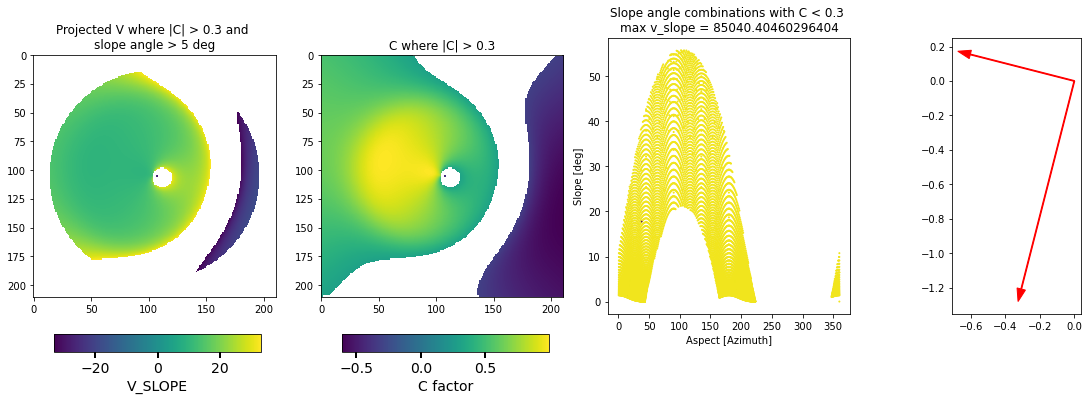

In [18]:
threshold = 0.3

C_mask = np.ma.masked_where((C > -threshold) & (C < threshold), C)
C_tr = np.ma.masked_where((abs(C) < threshold*0.99) | (abs(C) > threshold*1.18), np.ceil(abs(C)))
V_mask = np.ma.masked_where((C > -threshold) & (C < threshold) | (slope_DEM < 5), V_slope)


fig, ax = plt.subplots(1,4, figsize=(16,5))
im = ax[0].imshow(V_mask)
cax = fig.add_axes([0.05, 0.01, 0.18, 0.05])
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=np.nanmin(V_mask), vmax=np.nanmax(V_mask))
cbar = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='horizontal')
cbar.set_label('V_SLOPE', size=14)
cbar.ax.tick_params(labelsize=14, width=2, length=6) 
ax[0].set_title("Projected V where |C| > {} and \nslope angle > 5 deg".format(threshold))

ax[1].imshow(C_mask)
# ax[1].imshow(abs(C_tr), cmap="magma")
cax = fig.add_axes([0.3, 0.01, 0.18, 0.05])
norm = mpl.colors.Normalize(vmin=np.nanmin(C), vmax=np.nanmax(C))
ax[1].set_title("C where |C| > {}".format(threshold))

cbar = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='horizontal')
cbar.set_label('C factor', size=14)
cbar.ax.tick_params(labelsize=14, width=2, length=6) 

im = ax[2].scatter(aspect_DEM[(C > -threshold) & (C < threshold)], 
                   slope_DEM[(C > -threshold) & (C < threshold)], 
                   s=1, c=V_slope[(C > -threshold) & (C < threshold)])
ax[2].set_title("Slope angle combinations with C < {} \nmax v_slope = {}".format(threshold, np.max(V_slope)))
ax[2].set_xlabel("Aspect [Azimuth]")
ax[2].set_ylabel("Slope [deg]")

ax[3].arrow(0,0, 2*D_N, -2*D_E, 
            width=0.005, head_width=0.05, facecolor="r", edgecolor="r")
ax[3].arrow(0,0, -D_E, -D_N, 
            width=0.005, head_width=0.05, facecolor="r", edgecolor="r")
ax[3].set_aspect('equal', 'box')

plt.tight_layout()

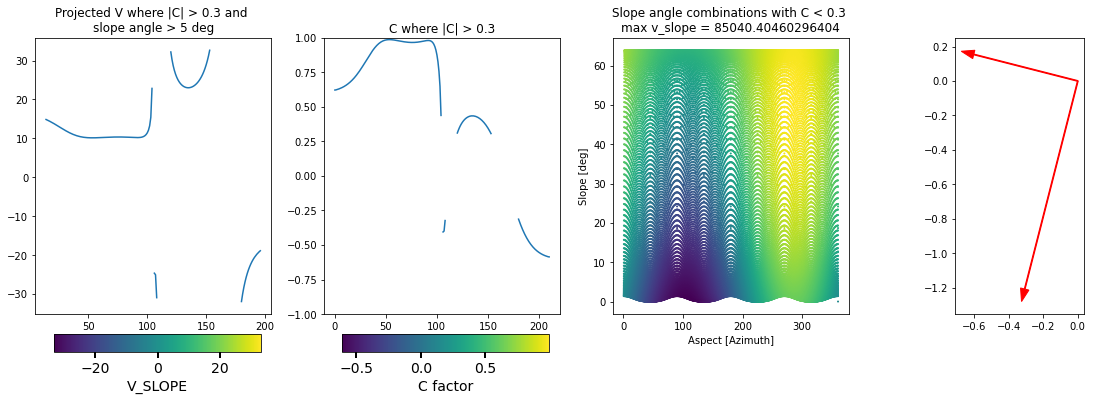

In [19]:
fig, ax = plt.subplots(1,4, figsize=(16,5))

im = ax[0].plot(V_mask[106,:])
cax = fig.add_axes([0.05, 0.01, 0.18, 0.05])
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=np.nanmin(V_mask), vmax=np.nanmax(V_mask))
cbar = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='horizontal')
cbar.set_label('V_SLOPE', size=14)
cbar.ax.tick_params(labelsize=14, width=2, length=6) 
ax[0].set_title("Projected V where |C| > {} and \nslope angle > 5 deg".format(threshold))

ax[1].plot(C_mask[106,:])
ax[1].set_ylim(-1,1)
cax = fig.add_axes([0.3, 0.01, 0.18, 0.05])
norm = mpl.colors.Normalize(vmin=np.nanmin(C), vmax=np.nanmax(C))
ax[1].set_title("C where |C| > {}".format(threshold))

cbar = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='horizontal')
cbar.set_label('C factor', size=14)
cbar.ax.tick_params(labelsize=14, width=2, length=6) 

# im = ax[2].scatter(aspect_DEM[(C > -threshold) & (C < threshold)], 
#                    slope_DEM[(C > -threshold) & (C < threshold)], 
#                    s=1, c=V_slope[(C > -threshold) & (C < threshold)])

im = ax[2].scatter(aspect_DEM, 
                   slope_DEM, 
                   s=1, c=C)
ax[2].set_title("Slope angle combinations with C < {} \nmax v_slope = {}".format(threshold, np.max(V_slope)))
ax[2].set_xlabel("Aspect [Azimuth]")
ax[2].set_ylabel("Slope [deg]")

ax[3].arrow(0,0, 2*D_N, -2*D_E, 
            width=0.005, head_width=0.05, facecolor="r", edgecolor="r")
ax[3].arrow(0,0, -D_E, -D_N, 
            width=0.005, head_width=0.05, facecolor="r", edgecolor="r")
ax[3].set_aspect('equal', 'box')

plt.tight_layout()

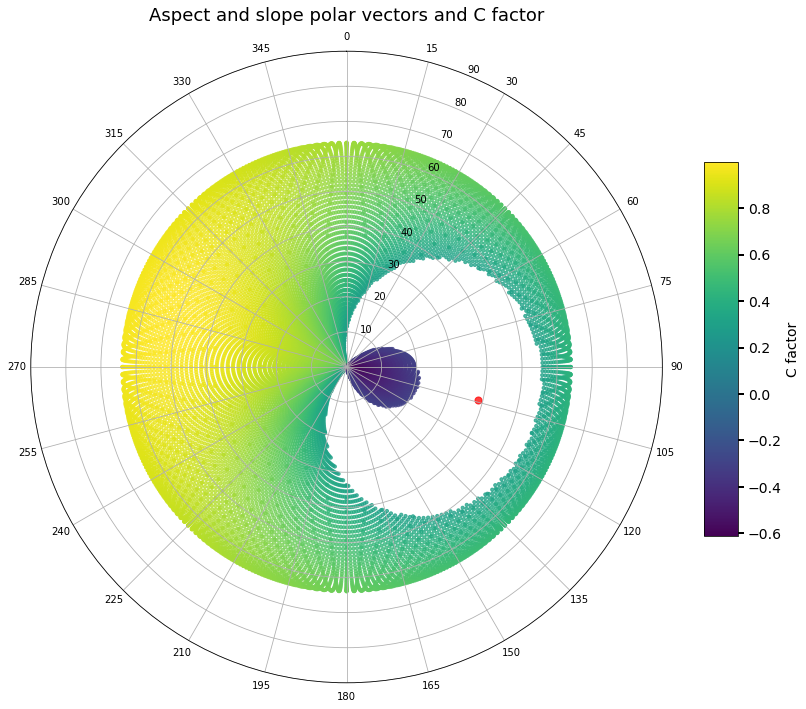

In [20]:
fig = plt.figure(figsize=(16,10))

ax = fig.add_subplot(111, projection='polar')

ax.set_rlim((0,90))
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_thetagrids(np.arange(0, 360, 15), labels=np.arange(0, 360, 15))


ax.scatter(np.deg2rad(aspect_DEM[abs(C)>0.3].ravel()), slope_DEM[abs(C)>0.3].ravel(), c=C[abs(C)>0.3], alpha=0.75, s=10)

#plot LOS unit vector
ax.scatter(np.deg2rad(mean_flight_dir-90), mean_incidence_angle, alpha=0.75, s=50, color="red")

cax = fig.add_axes([0.81, 0.245, 0.03, 0.52])
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=np.min(C), vmax=np.max(C))
cbar = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='vertical')
cbar.set_label('C factor', size=14)
cbar.ax.tick_params(labelsize=14, width=2, length=6) 


fig.suptitle("Aspect and slope polar vectors and C factor", size=18)
fig.tight_layout()

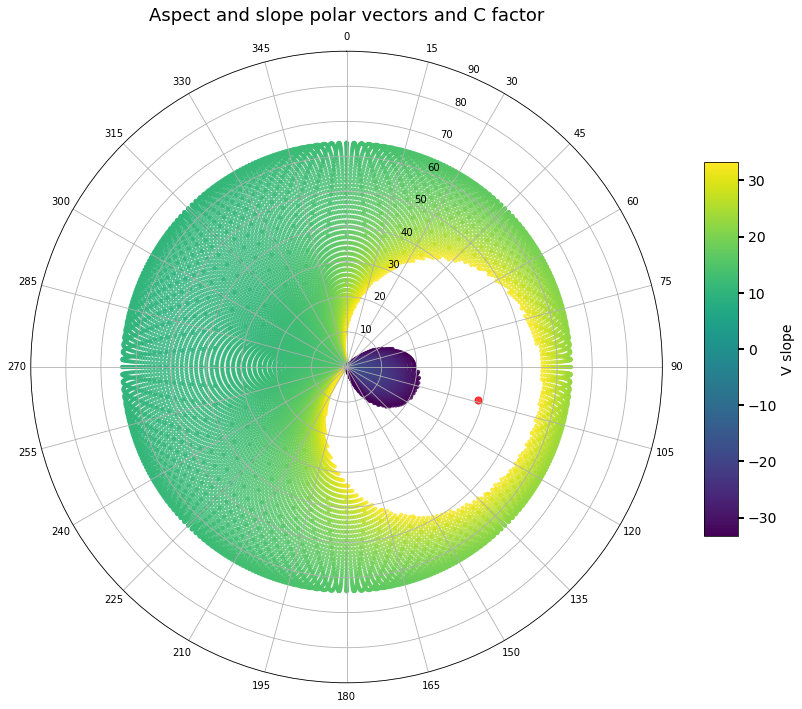

In [21]:
fig = plt.figure(figsize=(16,10))

ax = fig.add_subplot(111, projection='polar')

ax.set_rlim((0,90))
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_thetagrids(np.arange(0, 360, 15), labels=np.arange(0, 360, 15))


ax.scatter(np.deg2rad(aspect_DEM[abs(C)>0.3].ravel()), slope_DEM[abs(C)>0.3].ravel(), c=V_slope[abs(C)>0.3], alpha=0.75, s=10)

#plot LOS unit vector
ax.scatter(np.deg2rad(mean_flight_dir-90), mean_incidence_angle, alpha=0.75, s=50, color="red")

cax = fig.add_axes([0.81, 0.245, 0.03, 0.52])
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=np.min(V_slope[abs(C)>0.3]), vmax=np.max(V_slope[abs(C)>0.3]))
cbar = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='vertical')
cbar.set_label('V slope', size=14)
cbar.ax.tick_params(labelsize=14, width=2, length=6) 


fig.suptitle("Aspect and slope polar vectors and C factor", size=18)
fig.tight_layout()

## R index

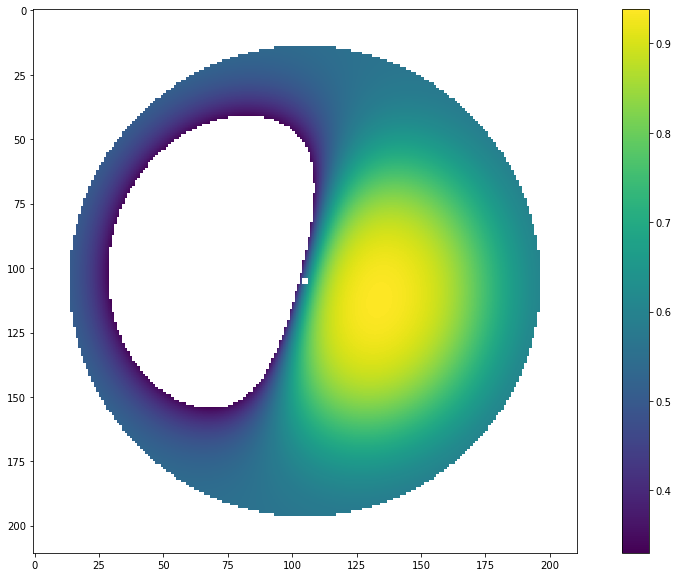

In [64]:
#RI   sin( S  sin( A    90 )   )

#There is a weird variable search for its meaning

# Notti 2008 describes better this index
# R= R-index,S= slope   derived   from   DEM,Aα= aspect derived from DEM 
# and correct with angle from north of the satellite track (i.e.−8◦for TerraSAR 
# descending +188◦forALOS ascending geometry),θ= incident angle of LOS
# R= −sin(arctan(tanS·sinAα)−θ)

R_index = -np.sin(np.arctan(np.tan(np.deg2rad(slope_DEM))*
                            np.sin(np.deg2rad(aspect_DEM)-np.deg2rad(mean_flight_dir)) - 
                            np.deg2rad(mean_incidence_angle)))

R_mask = np.ma.masked_where((slope_DEM < 5) | (R_index <0.33), R_index)

fig, ax = plt.subplots(1,1, figsize=(16,10))
im = ax.imshow(R_mask)
cbar =  plt.colorbar(im)



# plot the C factor and see its relation with aspect and slope

#check differences between slope decompositions

# Projection of a mogi model

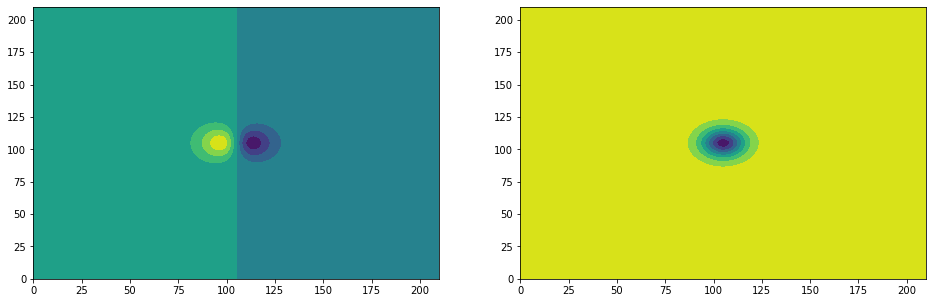

In [18]:
d = 500 #m depth
delta_V = -10000 #m pressure change

def Uv2(b=2500, n=211):
    x, y = np.meshgrid(np.linspace(-b,b,n),
                        np.linspace(-b,b,n))
    r = np.sqrt((x**2)+(y**2))
    
    Uv=(3*delta_V*d)/(4*np.pi*(((d**2)+(r**2))**(3.5)))
    
    return Uv

def Uh2(b=2500, n=211):
    x, y = np.meshgrid(np.linspace(-b,b,n),
                    np.linspace(-b,b,n))
    r = np.sqrt((x**2)+(y**2))
    Uh=(3*delta_V*x)/(4*np.pi*(((d**2)+(r**2))**(3.5)))
    return Uh*1E+16

Uv = Uv2()
Uh = Uh2()

fig, ax = plt.subplots(1,2, figsize=(16,5))
im = ax[0].contourf(Uh)
im = ax[1].contourf(Uv)


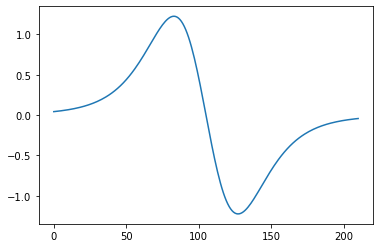

In [19]:
plt.plot(Uh[55,:])